<a href="https://colab.research.google.com/github/Yohan0358/Study_GAN/blob/main/DCGAN(210714).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN

![](https://pytorch.org/tutorials/_images/dcgan_generator.png)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision import utils

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device type : ', device)

torch.manual_seed(2021)
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 64
epochs = 100
batch_size = 100
lr = 0.0002
image_channel = 1
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    mean = [0.5], std = [0.5])   # 1 channel
                                ])

device type :  cuda


In [7]:
# 데이터 다운로드
# mnist = datasets.MNIST('./mnist/',
#                        train = True,
#                        transform = transform,
#                        download = True)

# 데이터 다운로드
Fmnist = datasets.FashionMNIST('./Fmnist/',
                       train = True,
                       transform = transform,
                       download = True)

# dataloader
data_loader = DataLoader(Fmnist, 
                         batch_size = batch_size, 
                         shuffle = True)


Extracting ./Fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./Fmnist/FashionMNIST/raw




Extracting ./Fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./Fmnist/FashionMNIST/raw




Extracting ./Fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./Fmnist/FashionMNIST/raw




Extracting ./Fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./Fmnist/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


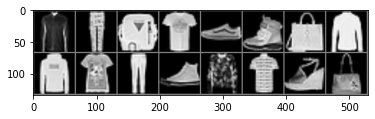

In [8]:
def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap = 'gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

ex_batch_img, _ = next(iter(data_loader))
imshow_grid(ex_batch_img[:16, :])

In [9]:
# DCGAN

# weight값을 초기화 해주는 function 정의
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.01)
        nn.init.constant_(m.bias.data, 0)



class Generator(nn.Module):
    def __init__(self, latent_size = latent_size, image_size = image_size):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, 4, 1, 0, bias = False),
            nn.LeakyReLU(0.2),
            # (None, 100, 1, 1) -> (None, 512, 4, 4)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # (None, 512, 4, 4) -> (None, 256, 8, 8)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),            
            # (None, 256, 8, 8) -> (None, 128, 16, 16)
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            # (None, 128, 16, 16) -> (None, 64, 32, 32)
            nn.ConvTranspose2d(64, image_channel, 4, 2, 1, bias = False),
            nn.Tanh()
            # (None, 64, 32, 32) -> (None, image_channel, 64, 64) : (-1, 1)로 normalizing
            )
        
    def forward(self, x):
        x = self.main(x)
        return x

class Descriminator(nn.Module):
    def __init__(self, image_channel = image_channel):
        super(Descriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(image_channel, 64, 4, 2, 1, bias= False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            # (None, 64, 64, image_channel) -> (None, 32, 32, 64)
            nn.Conv2d(64, 128, 4, 2, 1, bias= False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),            
            # (None, 32, 32, 64) -> (None, 16, 16, 128)
            nn.Conv2d(128, 256, 4, 2, 1, bias= False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),                 
            # (None, 16, 16, 128) -> (None, 8, 8, 256)
            nn.Conv2d(256, 512, 4, 2, 1, bias= False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),                 
            # (None, 8, 8, 256) -> (None, 4, 4, 512)
            nn.Conv2d(512, 1, 4, 1, 0, bias= False),
            # (None, 4, 4, 512) -> (None, 1, 1, 1)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [10]:
# noise define
def generate_noise(latent_size = latent_size, batch_size = batch_size):
    return torch.randn(batch_size, latent_size, 1, 1)

z = generate_noise().to(device)

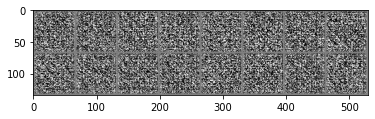

In [11]:
G = Generator().to(device)
D = Descriminator().to(device)
img_fake = G(z)

imshow_grid(img_fake[:16])

In [12]:
# Optimizer
G_optim = torch.optim.Adam(G.parameters(), lr = lr)
D_optim = torch.optim.Adam(D.parameters(), lr = lr)

# Loss function
criterion = nn.BCELoss()

In [21]:
# training

def DCGAN_train(epochs = epochs):
    history_DCGAN = {}
    dloss_list = []
    gloss_list = []

    for epoch in range(epochs):
        d_losses = 0
        g_losses = 0
        for i, (image, _) in enumerate(data_loader):

            image = image.to(device)
            img_size = image.size(1)
            z = generate_noise().to(device)

            real_labels = torch.ones(batch_size, img_size).to(device) # (batch_size, image_channel)
            fake_labels = torch.zeros(batch_size, img_size).to(device)

            # Descriminator 학습
            real_output = D(image)
            fake_output = D(G(z))

            real_loss = criterion(real_output.view(-1), real_labels.view(-1))
            fake_loss = criterion(fake_output.view(-1), fake_labels.view(-1))

            D_x = real_output.cpu().view(-1).mean().item()
            D_G_z1 = fake_output.cpu().view(-1).mean().item()

            d_loss = real_loss + fake_loss

            D_optim.zero_grad()
            d_loss.backward()
            D_optim.step()



            # Generator 학습

            output = D(G(z))

            D_G_z2 = output.cpu().view(-1).mean().item()
            g_loss = criterion(output.view(-1), real_labels.view(-1))
            G_optim.zero_grad()
            g_loss.backward()
            G_optim.step()

            d_losses += d_loss / len(data_loader)
            g_losses += g_loss / len(data_loader)

        print(f'[{epoch + 1} / {epochs}] D_loss : {d_losses:.4f} \t G_loss : {g_losses:.4f} \t D(x) : {D_x} \t D(G(z1)) : {D_G_z1} \t D(G(z2)) : {D_G_z2}')     
        if (epoch + 1) % 1 == 0:
            imshow_grid(G(z)[:16])

        dloss_list.append(d_losses.item())
        gloss_list.append(g_losses.item())

    history_DCGAN['D_loss'] = dloss_list
    history_DCGAN['G_loss'] = gloss_list
    return history_DCGAN

[1 / 2] D_loss : 0.0294 	 G_loss : 9.1867 	 D(x) : 0.9997376799583435 	 D(G(z1)) : 0.03155944496393204 	 D(G(z2)) : 0.011649085208773613


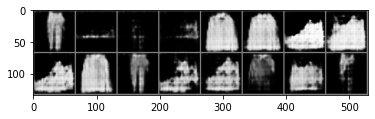

[2 / 2] D_loss : 0.0258 	 G_loss : 8.2524 	 D(x) : 0.9972002506256104 	 D(G(z1)) : 0.0003417793777771294 	 D(G(z2)) : 0.00011541058483999223


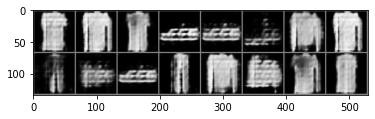

In [22]:
hist = DCGAN_train(2)

In [ ]:
# 모델 저장
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [23]:
hist

{'D_loss': [tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>)],
 'G_loss': [tensor(9.1867, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(8.2524, device='cuda:0', grad_fn=<AddBackward0>)]}